In [7]:
# ESSENTIALS
import numpy as np
import matplotlib.pyplot as plt

# CLUSTERING AND RANDOM FOREST
import skfuzzy as fuzz
from sklearn.datasets import make_blobs
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

# DATA LIBRARIES
import geopandas as gpd
from glob import glob
import pandas as pd

# PREFERENCES
pd.set_option('display.max_columns', 500)
# plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (15, 15)
plt.rcParams.update({'font.size': 14})

Define our Scikit-Learn Compliant Class so we can implement validation schemes within. Only two methods required: predict() and fit()

In [2]:
class ModelSelector():

    def __init__(self, c_kwargs={}, rf_kwargs={}):
       self.c_kwargs=c_kwargs        # CLUSTERING HYPERPARAMETERS
       self.rf_kwargs=rf_kwargs      # RANDOM FOREST HYPERPARAMETERS
       self.m = 2                    # EXPONENTIATION COEFFICIENT FOR CLUSTERING. TODO: MAKE ADJUSTABLE

    def fuzzyCluster(self, data):
        # Wraps Fuzzy Cluster function, only outputting percent belongs and formal cluster.

        # CHECK THAT REQUIRED FIELDS ARE IN KWARGS, IF NOT ADD
        if "error" not in self.c_kwargs:
            self.c_kwargs['error']=0.005

        if "maxiter" not in self.c_kwargs:
            self.c_kwargs['maxiter']=1000

        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, self.n_centers, self.m, **self.c_kwargs)
        label = np.argmax(u, axis=0)
        return cntr, u, fpc, label

    def howManyClusters(self, X, mintest=2,maxtest=15):
        # Determines how many clusters should be used using the Fuzzy Partitions Coefficient (FPC)
        # https://scikit-fuzzy.github.io/scikit-fuzzy/auto_examples/plot_cmeans.html#example-plot-cmeans-py
        # TODO: FIGURE OUT IF THIS METHOD IS APPROPRIATE OR NOT
        return 3
        fpcs = []
        listtests = np.arange(mintest,maxtest)
        for ncenters in listtests:
            self.n_centers = ncenters
            _, _, fpc, _ = self.fuzzyCluster(X)
            fpcs.append(fpc)
        return listtests[np.argmax(fpcs)]

    def train_rf(self, X_train, y_train, rf_controls={}):
        # ADAPTED FROM https://stackoverflow.com/questions/28489667/combining-random-forest-models-in-scikit-learn

        # RF CONTROLS PASSED DIRECTLY FROM PARAMETER, DEFAULT IS EMPTY
        rf = RandomForestRegressor(**rf_controls) 

        # RF FITTING 
        rf.fit(X_train, y_train)

        return rf

    def fit(self, attributes, model_perf):
        # GET NUMBER OF CLUSTERS VIA MAXIMUM FUZZY PARTITION COEFFICIENT 
        self.n_centers = self.howManyClusters(model_perf)

        # RUN CLUSTERING AND SAVE CENTERS FOR FUTURE PREDICTIONS
        cntr, u, fpc, label = self.fuzzyCluster(model_perf)
        # cntr:  CLUSTER CENTERS, WHICH ARE ON N-DIM MODEL PERFORMANCE SPACE
        #        WHERE N IS THE NUMBER OF MODELS BEING COMPARED. 
        # u:     CLUSTER MEMBERSHIP MATRIX (% BELONGING)
        # fpc:   FUZZY PARTITION COEFFICIENT FOR CLUSTERING RUN
        # label: "CLOSEST CLUSTER", DEFINED BY MAXIMUM CLUSTER MEMBERSHIP (argmax(u))
        self.centers = cntr

        u = u.T # FLIP DIMENSIONS FOR U MATRIX

        # CREATE RANDOM FOREST AND TRAIN
        self.rf = self.train_rf(attributes, u, rf_controls=self.rf_kwargs)
        #print(r2_score(self.rf.predict(attributes), u))

        return self

    def predict(self, attributes):

        # CHECK WHETHER MODEL HAS BEEN TRAINED
        if self.rf is None:
            raise(Exception("ModelSelector isn't trained!"))

        # GET RANDOM FOREST PREDICTION
        pred_cluster_scores = self.rf.predict(attributes)

        self.pred_cluster_scores = pred_cluster_scores # FOR TROUBLESHOOTING, DELETEME

        # CALCULATE PROBABILITY OF INDIVIDUAL MODELS BY TAKING INTO ACCOUNT LIKELIHOOD THAT THEY ARE IN A CLUSTER (CLUSTER SCORES)
        # AND PERCENT TIMES THAT A GIVEN MODEL IS BETTER IN A GIVEN CLUSTER (CENTERS)
        prob_model = np.matmul(pred_cluster_scores, self.centers)

        self.prob_model = prob_model # FOR TROUBLESHOOTING, DELETEME

        return prob_model


Read CAMELS Data

In [3]:
# FILEPATH TO SHAPEFILE CONTAINING CAMELS DATASET
camelsdir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\HCDN_nhru_final\HCDN_nhru_final_671.shp"

# DIRECTORY TO FOLDER CONTAINING CAMELS ATTRIBUTE TEXTFILES
# PRIOR TO THIS STEP MAKE SURE THE README IN THE FILE SYSTEM HAS BEEN REMOVED (or the file extension has been changed)
attdir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\camels_attributes_v2.0\camels_attributes_v2.0\\"

# READ CAMELS DATASET
camels = gpd.read_file(camelsdir)


# COPY TO KEEP ORIGINAL IN MEMORY
camels_df = camels 

# LOOP THROUGH AND JOIN
filelist = glob(attdir + "*.txt")
for i in filelist:
    currdf = pd.read_csv(i, sep=";")
    camels_df = camels_df.merge(currdf, how='left', left_on="hru_id", right_on="gauge_id")

# DEFINE WHAT WE WANT TO RUN ON
perf_dir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\Repo\nextgen-form-eval\FrankTests\data\JonathanTests\\"
perf_prefixes = ["daymet_time_split1", "daymet_time_split2", "nldas_time_split1", "nldas_time_split2"]
perf_prefixes_abb = ["daymetS1", "daymetS2", "nldasS1", "nldasS2"]
perf_metrics = ["KGE"]

# CONTAINER FOR PERFORMANCE VARIABLE NAMES
perfvars = list()
perfvars_split = list()


# LOOP THROUGH EACH TO ADD TO CAMELS DATASET AND SAVE COLUMN NAME
for i in range(0, len(perf_prefixes)):
    for ii in range(0, len(perf_metrics)):
        currdir = perf_dir + perf_prefixes[i] + "_" + perf_metrics[ii] + ".csv"
        currdf = pd.read_csv(currdir).add_prefix(perf_prefixes_abb[i] + "_" + perf_metrics[ii] + "_")
        first_col_name = currdf.columns.to_list()[0]
        perfvars.extend(currdf.columns.to_list()[1:])
        perfvars_split.append(currdf.columns.to_list()[1:])
        camels_df = camels_df.merge(currdf, how='right', left_on="hru_id", right_on=first_col_name)


# CLEAN UP NONSENSICAL DATA (EG, BASIN LABELS)
# SO LETS GET A LIST OF VARIABLE NAMES WE WANT TO KEEP.

# TO START WE WILL KEEP THE SAME VARIABLES AS Kratzert et al. 2019, AS SHOWN BY OUR
# INTERNAL SPREADSHEET Attributes_CAMELS_vs_NHDPlus
varstokeep = ['p_mean',
'pet_mean',
'aridity',
'p_seasonality',
'frac_snow',                   # In spreadsheet as 'frac_snow_daily'
'high_prec_freq',
'high_prec_dur',
'low_prec_freq',
'low_prec_dur',
'elev_mean_x',                 # In spreadsheet as 'elev_mean' 
'slope_mean',
'area_gages2',
'frac_forest',                 # In spreadsheet as 'forest_frac'
'lai_max',
'lai_diff',
'gvf_max',
'gvf_diff',
'soil_depth_pelletier',
'soil_depth_statsgo',
'soil_porosity',
'soil_conductivity',
'max_water_content',
'sand_frac',
'silt_frac',
'clay_frac',
'carbonate_rocks_frac',         # In spreadsheet as 'carb_rocks_frac'
'geol_permeability']

# DO NOT DELETE!!! ---------------------------------------------------------------------------------------------
# CHECK OUR VALUES ARE GOOD
tflist = []
for i in varstokeep: # LOOP THROUGH AND CHECK COLUMN NAME IS IN DATAFRAME, STORE RESULT IN TFLIST
    tflist.append(i in camels_df)

# CONVERT TF LIST TO NUMPY ARRAY, THEN CHECK IF ALL ARE TRUE. IF NOT, PRINT WHICH ONE ISN'T AND RAISE EXCEPTION
tflist = np.array(tflist)
if np.any(np.logical_not(tflist)):
    print("\n".join(np.array(varstokeep)[np.logical_not(tflist)]))
    raise(Exception("Printed values not in CAMELS DataFrame"))
# ---------------------------------------------------------------------------------------------------------------

inputdataset = camels_df[varstokeep]
outputdataset = camels_df[perfvars]


c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)
c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


daymet_time_split1
daymet_time_split2
nldas_time_split1
nldas_time_split2


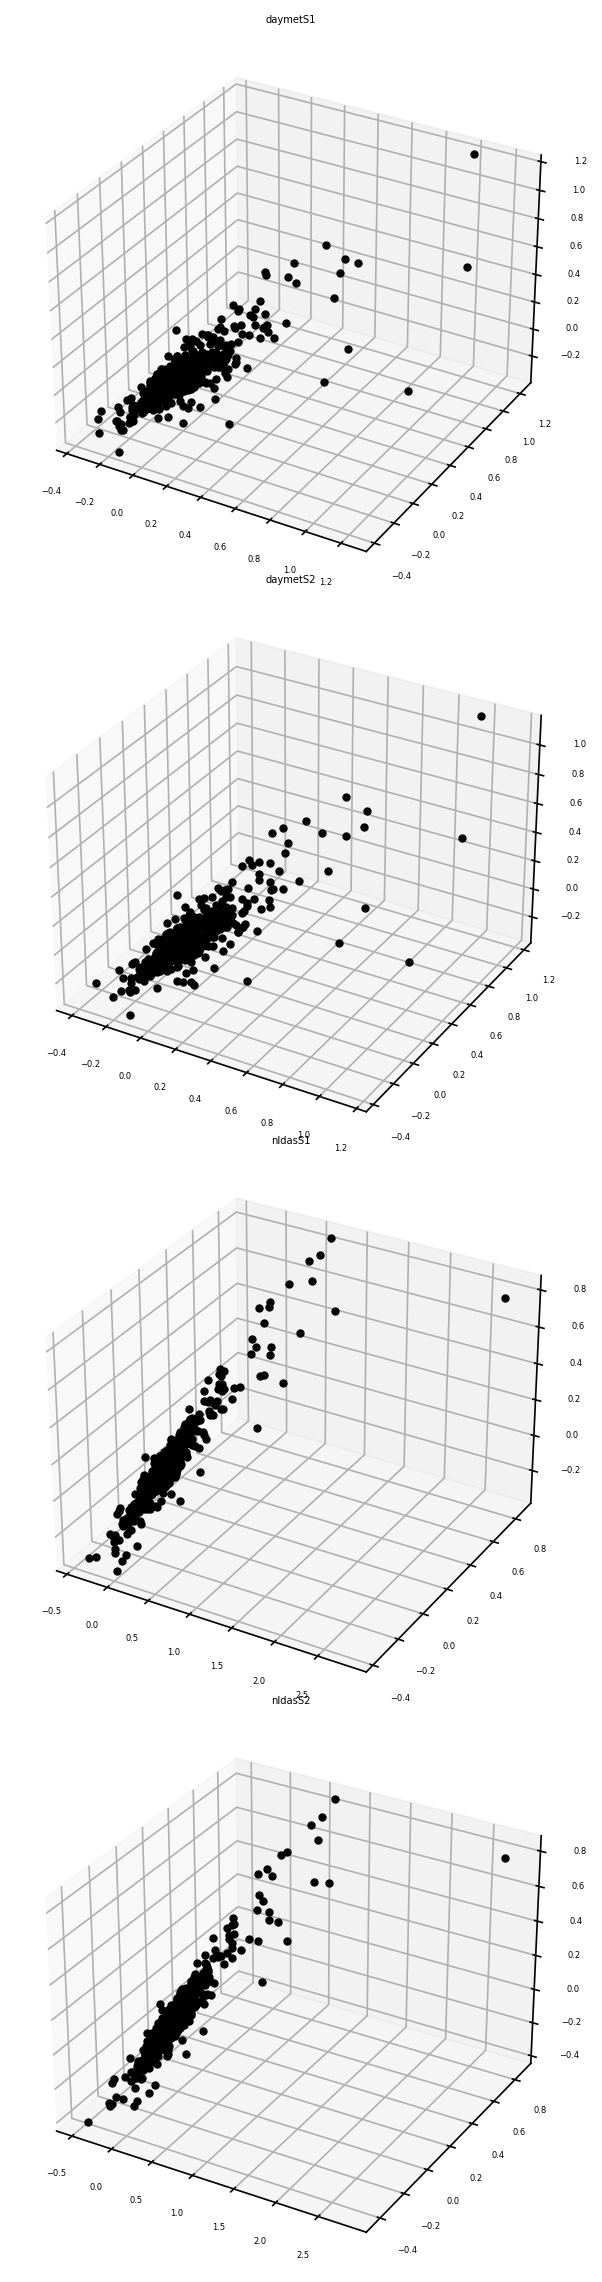

In [4]:
def prettify(a, bott = 10, top = 90):
    b = np.nanpercentile(a, bott)
    a = a - b
    t = np.nanpercentile(a, top)
    a = a / t
    a = np.where(a > 1, 1, a)
    a = np.where(a < 0, 0, a)
    return a

def plotClusters_alpha(X, labs, ncenters, ax, u): # TODO: I ENDED UP NOT USING THIS FUNCTION SO IDK IF IT WORKS
    # Wraps a plotting function to return different colored clusters in a 3D axis
    colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']
    ax = plt.axes(projection='3d')
    for j in range(ncenters):
        alpha_values = prettify(u[:, np.argmin(u, axis=0)])
        ax.scatter(X[labs == j, 0], X[labs == j, 1], X[labs==j, 2], '.', color=colors[j], alpha=alpha_values)
    return ax

kf = KFold(n_splits=5, shuffle=True)
 # FIGURE
fig, axs = plt.subplots(len(perf_prefixes), 1, subplot_kw=dict(projection='3d'))
fig.tight_layout()

for i in range(0, len(perf_prefixes)):

    # OUTPUT DATASETS FOR EACH SPLIT
    currout = outputdataset[perfvars_split[i]]
    print(perf_prefixes[i])

    # CONTAINER FOR CLUSTER VALUES
    testvalues = np.zeros((inputdataset.shape[0], len(perfvars_split[i])))
    
    # KFOLD SPLIT OF DATASETS
    for train, test in kf.split(inputdataset):

        # TRAIN MODEL ON TRAINING SET
        model = ModelSelector()
        model.fit(inputdataset.iloc[train, :], currout.iloc[train, :])

        # print(r2_score(model.predict(inputdataset.iloc[train, :]), currout.iloc[train, :]))

        # PERFORM PREDICTION ON TEST SET
        model_pred = model.predict(inputdataset.iloc[test, :])

        testvalues[test, :] = model_pred

    # CALCULATE ERROR OF FRAMEWORK
    pred_error = testvalues - currout.to_numpy()

    # PLOT
    axs[i].plot(pred_error[:,0], pred_error[:,1], pred_error[:,2], '.k')
    axs[i].set_title(perf_prefixes_abb[i])
    



In [5]:
def runFitMetric(fitmet, axs):
    # FILEPATH TO SHAPEFILE CONTAINING CAMELS DATASET
    camelsdir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\HCDN_nhru_final\HCDN_nhru_final_671.shp"

    # DIRECTORY TO FOLDER CONTAINING CAMELS ATTRIBUTE TEXTFILES
    # PRIOR TO THIS STEP MAKE SURE THE README IN THE FILE SYSTEM HAS BEEN REMOVED (or the file extension has been changed)
    attdir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\camels_attributes_v2.0\camels_attributes_v2.0\\"

    # READ CAMELS DATASET
    camels = gpd.read_file(camelsdir)

    # COPY TO KEEP ORIGINAL IN MEMORY
    camels_df = camels 

    # LOOP THROUGH AND JOIN
    filelist = glob(attdir + "*.txt")
    for i in filelist:
        currdf = pd.read_csv(i, sep=";")
        camels_df = camels_df.merge(currdf, how='left', left_on="hru_id", right_on="gauge_id")

    # DEFINE WHAT WE WANT TO RUN ON
    perf_dir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\Repo\nextgen-form-eval\FrankTests\data\JonathanTests\\"
    perf_prefixes = ["daymet_time_split1", "daymet_time_split2", "nldas_time_split1", "nldas_time_split2"]
    perf_prefixes_abb = ["daymetS1", "daymetS2", "nldasS1", "nldasS2"]
    perf_metrics = [fitmet]

    # CONTAINER FOR PERFORMANCE VARIABLE NAMES
    perfvars = list()
    perfvars_split = list()


    # LOOP THROUGH EACH TO ADD TO CAMELS DATASET AND SAVE COLUMN NAME
    for i in range(0, len(perf_prefixes)):
        for ii in range(0, len(perf_metrics)):
            currdir = perf_dir + perf_prefixes[i] + "_" + perf_metrics[ii] + ".csv"
            currdf = pd.read_csv(currdir).add_prefix(perf_prefixes_abb[i] + "_" + perf_metrics[ii] + "_")
            first_col_name = currdf.columns.to_list()[0]
            perfvars.extend(currdf.columns.to_list()[1:])
            perfvars_split.append(currdf.columns.to_list()[1:])
            camels_df = camels_df.merge(currdf, how='right', left_on="hru_id", right_on=first_col_name)


    # CLEAN UP NONSENSICAL DATA (EG, BASIN LABELS)
    # SO LETS GET A LIST OF VARIABLE NAMES WE WANT TO KEEP.

    # TO START WE WILL KEEP THE SAME VARIABLES AS Kratzert et al. 2019, AS SHOWN BY OUR
    # INTERNAL SPREADSHEET Attributes_CAMELS_vs_NHDPlus
    varstokeep = ['p_mean',
    'pet_mean',
    'aridity',
    'p_seasonality',
    'frac_snow',                   # In spreadsheet as 'frac_snow_daily'
    'high_prec_freq',
    'high_prec_dur',
    'low_prec_freq',
    'low_prec_dur',
    'elev_mean_x',                 # In spreadsheet as 'elev_mean' 
    'slope_mean',
    'area_gages2',
    'frac_forest',                 # In spreadsheet as 'forest_frac'
    'lai_max',
    'lai_diff',
    'gvf_max',
    'gvf_diff',
    'soil_depth_pelletier',
    'soil_depth_statsgo',
    'soil_porosity',
    'soil_conductivity',
    'max_water_content',
    'sand_frac',
    'silt_frac',
    'clay_frac',
    'carbonate_rocks_frac',         # In spreadsheet as 'carb_rocks_frac'
    'geol_permeability']

    inputdataset = camels_df[varstokeep]
    outputdataset = camels_df[perfvars]

    kf = KFold(n_splits=5, shuffle=True)
    # FIGURE
    # fig, axs = plt.subplots(len(perf_prefixes), 1, subplot_kw=dict(projection='3d'))

    axs[0].set_ylabel("Mean Absolute Error on " + fitmet)
    fig.tight_layout()

    for i in range(0, len(perf_prefixes)):

        # OUTPUT DATASETS FOR EACH SPLIT
        currout = outputdataset[perfvars_split[i]]
        print(perf_prefixes[i])

        # CONTAINER FOR CLUSTER VALUES
        testvalues = np.zeros((inputdataset.shape[0], len(perfvars_split[i])))
        
        # KFOLD SPLIT OF DATASETS
        for train, test in kf.split(inputdataset):

            # TRAIN MODEL ON TRAINING SET
            model = ModelSelector()
            model.fit(inputdataset.iloc[train, :], currout.iloc[train, :])

            # print(r2_score(model.predict(inputdataset.iloc[train, :]), currout.iloc[train, :]))

            # PERFORM PREDICTION ON TEST SET
            model_pred = model.predict(inputdataset.iloc[test, :])

            testvalues[test, :] = model_pred

        

        # CALCULATE ERROR OF DECISION SUPPORT
        pred_error = np.abs(testvalues - currout.to_numpy())

        if i == 0:
            minval = np.min(pred_error)
            maxval = np.max(pred_error)

        # PLOT
        axs[i].boxplot(pred_error, labels=["LSTM", "MC", "SAC"])
        axs[i].set_title(perf_prefixes_abb[i])
        axs[i].set_ylim(minval, maxval)

    return axs





c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)
c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


daymet_time_split1
daymet_time_split2
nldas_time_split1
nldas_time_split2


c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)
c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


daymet_time_split1
daymet_time_split2
nldas_time_split1
nldas_time_split2


c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)
c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


daymet_time_split1
daymet_time_split2
nldas_time_split1
nldas_time_split2


c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)
c:\Users\franc\anaconda3\envs\SITest\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


daymet_time_split1
daymet_time_split2
nldas_time_split1
nldas_time_split2


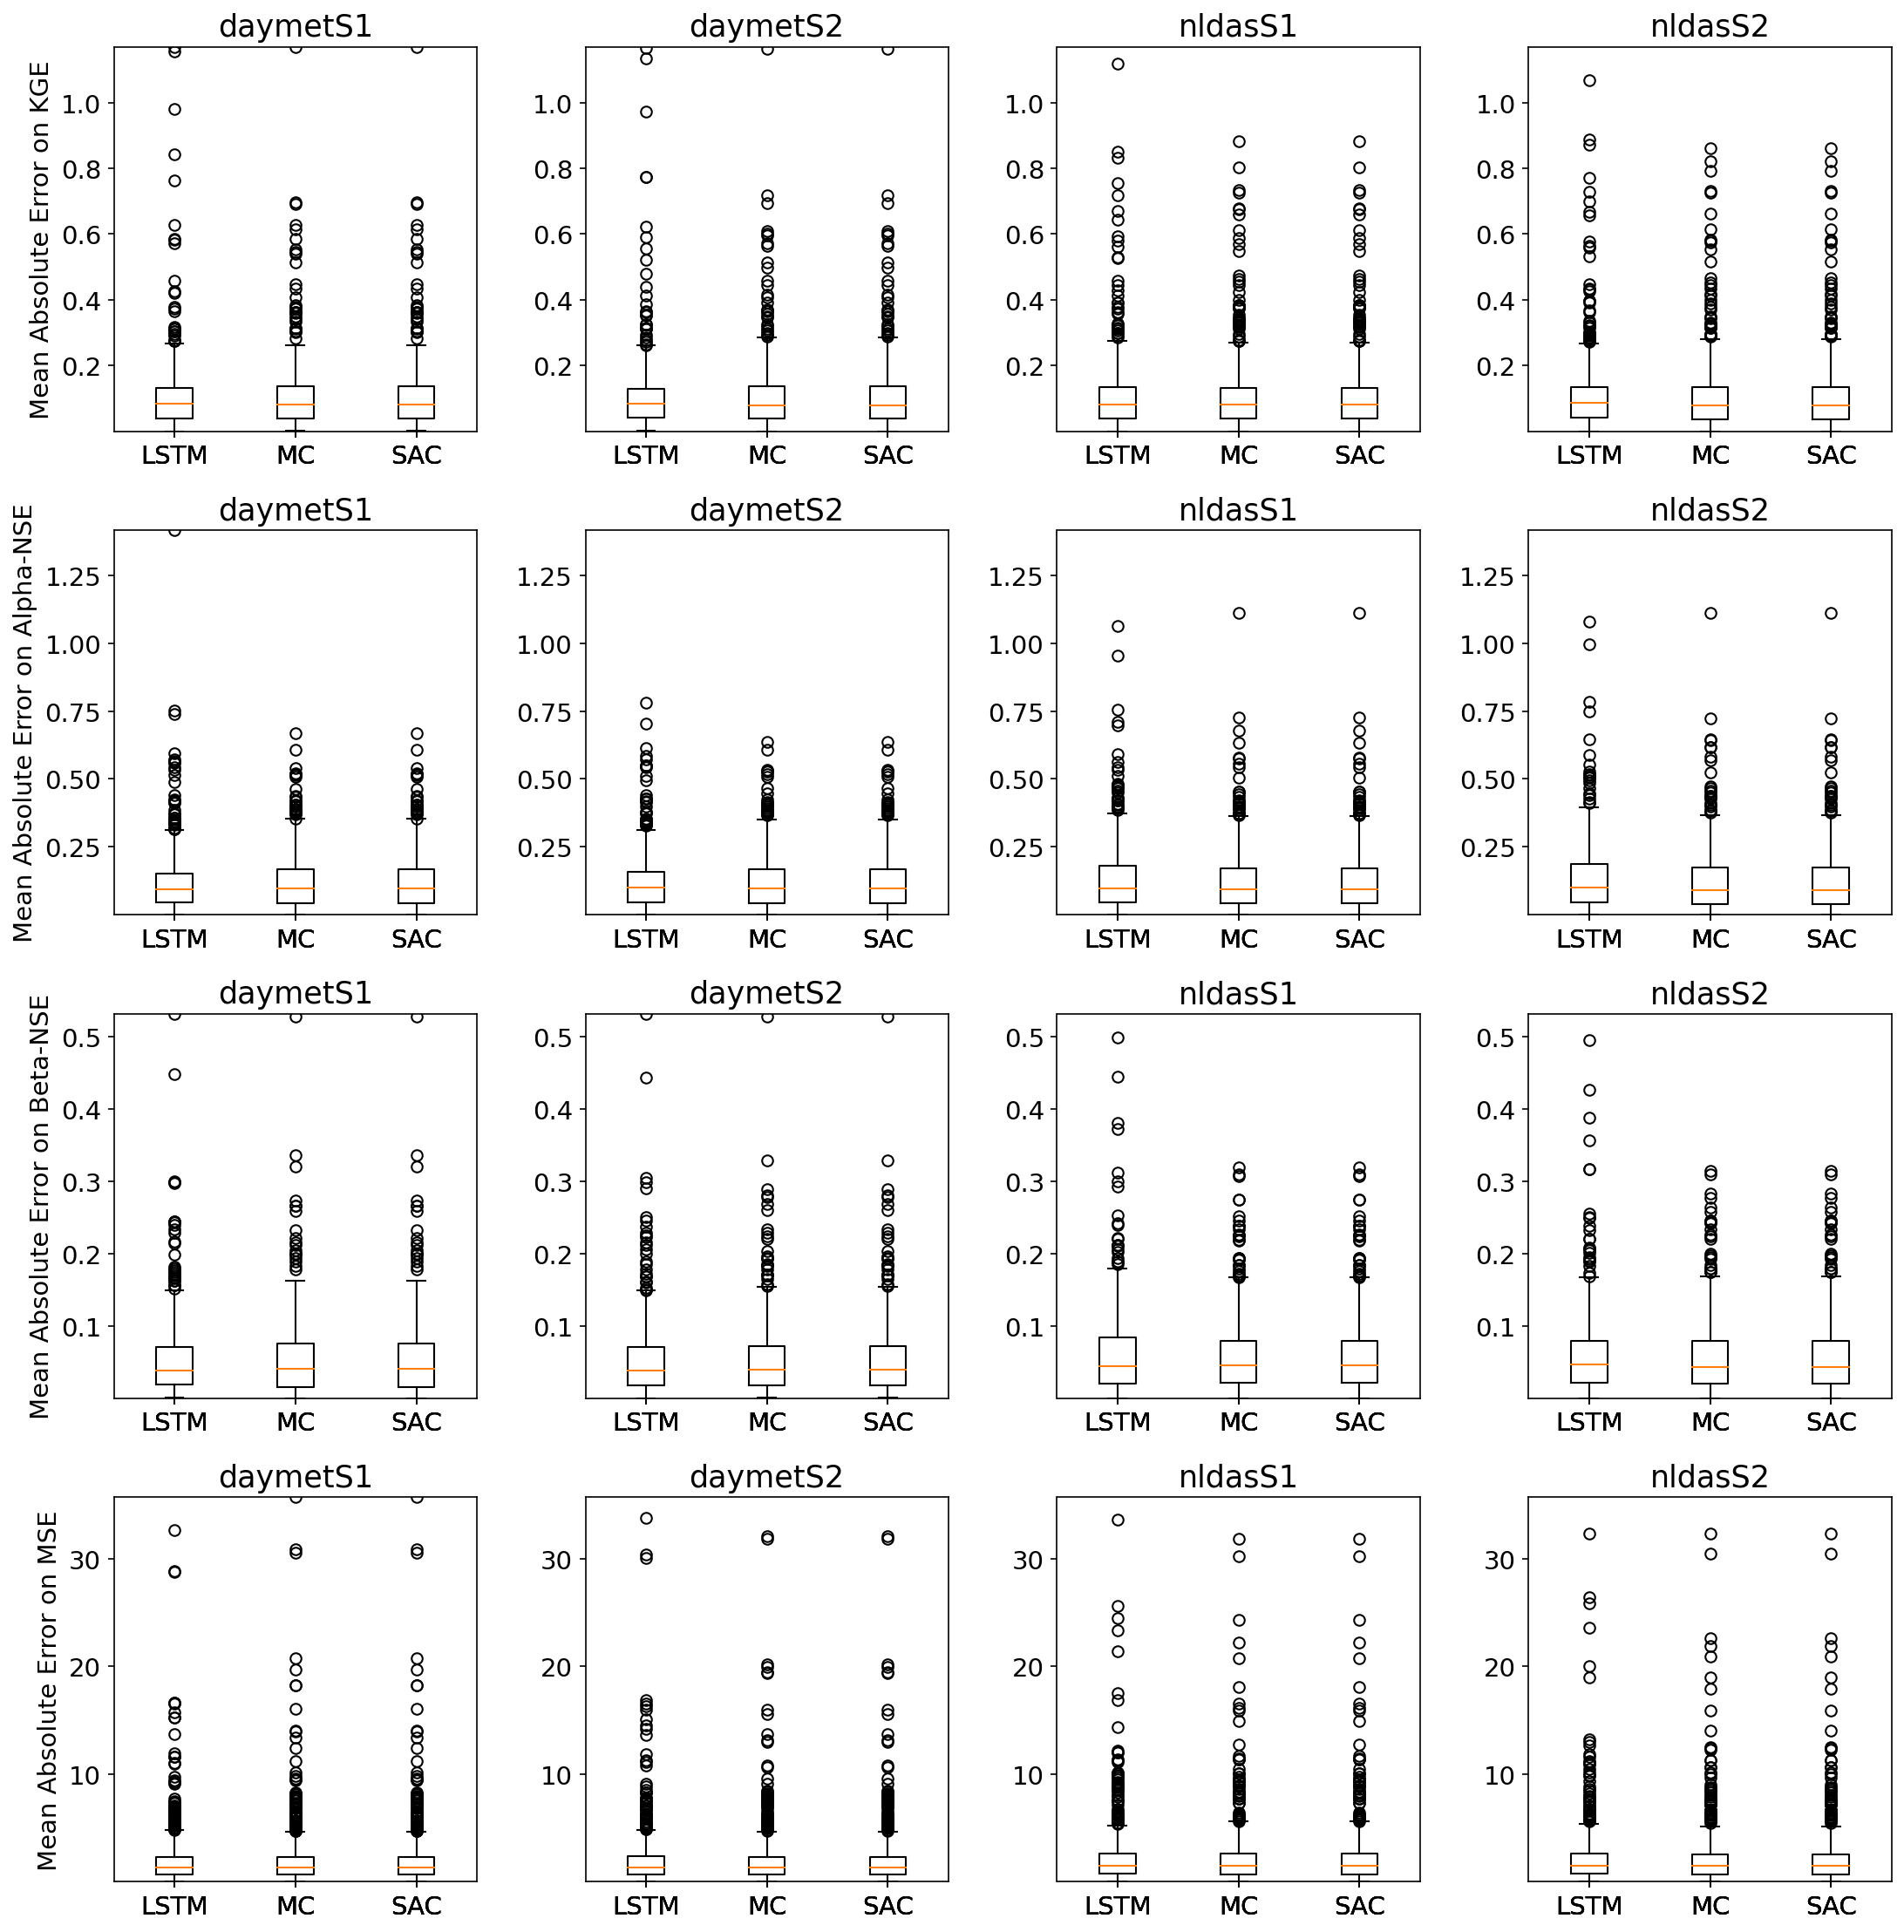

In [8]:
fig, axs = plt.subplots(4,4, sharex='row')
axs[0, :] = runFitMetric("KGE", axs[0, :])
axs[1, :] = runFitMetric("Alpha-NSE", axs[1, :])
axs[2, :] = runFitMetric("Beta-NSE", axs[2, :])
axs[3, :] = runFitMetric("MSE", axs[3, :])